In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 8.4MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=f23494042aa1ec5a82e50d5479e67ad18c86b11292c69cd61db177ae9a873e30
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-05 09:43:37--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-05 09:43:37--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb106c2a34ea5d21b841e09d9a6.dl.dropboxusercontent.com/cd/0/get/BIU0McE57Fpx5_yVrFDi02UrDP8cdQMILpqZvUGmZiyqKsiIlbjNIM2BNOBdIbGqmqQTRh_IZG2_s6qsxu3gcC7RVty-6bj78coJQRRaKbgS9t498gd3L-nbAXG2MKiYFow/file?dl=1# [following]
--2021-02-05 09:43:38--  https://ucb106c2a34ea5d21b841e09d9a6.dl.dropboxusercontent.com/cd/0/get/BIU0McE57Fpx5_yVrFDi02UrDP8cdQMILpqZvUGmZiyqKsiIlbjNIM2BNOBdIbGqmqQTRh_IZG2_s6qsxu3gcC7RVty-6bj78coJQRRaKbgS9t498gd3L-nbAXG2

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [7]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [8]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [9]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest50')
]

In [10]:
import timm
timm.list_models('*resnest50*')

['resnest50d', 'resnest50d_1s4x24d', 'resnest50d_4s2x40d']

In [11]:
learn = timm_learner(dls512, 'resnest50d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.3182567499825382e-06)

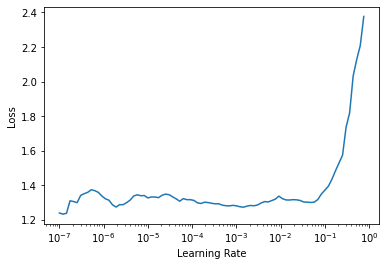

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.257241,0.938853,0.503058,0.489914,0.534591,00:30


Better model found at epoch 0 with valid_loss value: 0.93885338306427.


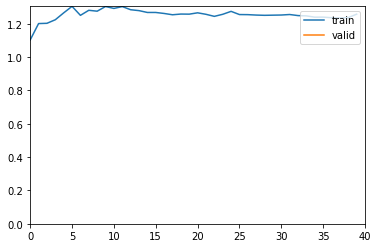

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.323570,0.974027,0.509174,0.495601,0.531447,00:36
1,1.328112,0.952979,0.510703,0.497191,0.556604,00:36
2,1.287765,0.937369,0.503058,0.489971,0.537736,00:35
3,1.264711,0.951728,0.487768,0.474777,0.503145,00:35
4,1.262228,0.934809,0.515290,0.501333,0.591195,00:35
5,1.278304,0.925785,0.503058,0.489426,0.509434,00:35
6,1.240802,0.915301,0.524465,0.510903,0.515723,00:36
7,1.242054,0.926127,0.504587,0.491176,0.525157,00:36
8,1.222163,0.910247,0.506116,0.492447,0.512579,00:35
9,1.212533,0.916769,0.492355,0.480556,0.544025,00:35


Better model found at epoch 0 with valid_loss value: 0.9740272164344788.


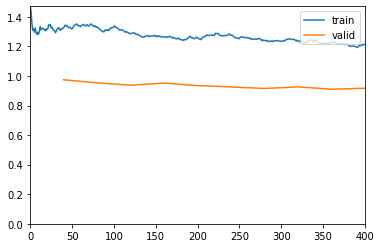

Better model found at epoch 1 with valid_loss value: 0.9529786705970764.
Better model found at epoch 2 with valid_loss value: 0.9373693466186523.
Better model found at epoch 4 with valid_loss value: 0.9348092079162598.
Better model found at epoch 5 with valid_loss value: 0.9257845878601074.
Better model found at epoch 6 with valid_loss value: 0.9153005480766296.
Better model found at epoch 8 with valid_loss value: 0.9102467894554138.


In [13]:
learn.fine_tune(10,base_lr=1e-5)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

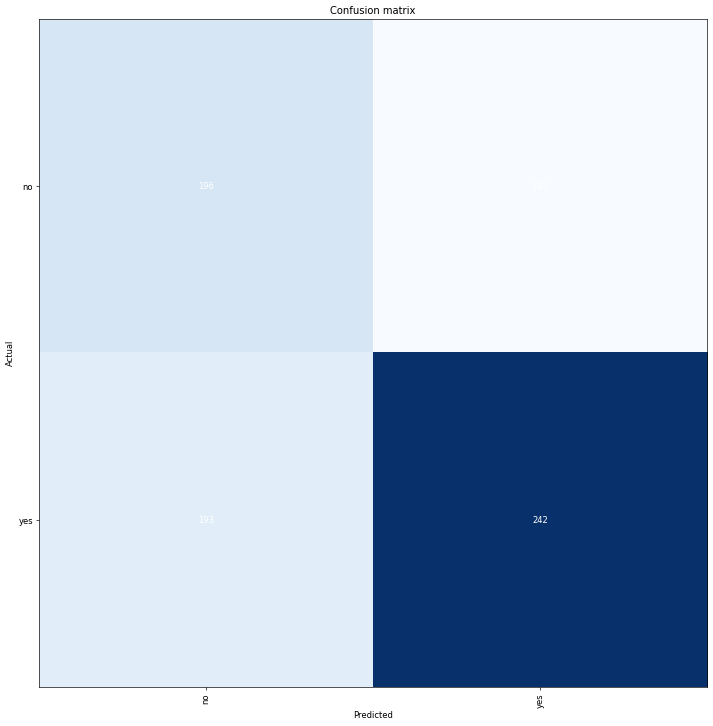

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5354523062705994.


(#4) [0.9018649458885193,0.5354523062705994,0.5641025641025641,0.5563218390804597]

In [17]:
learn.export(fname='resnet50.pkl')